# Windowing

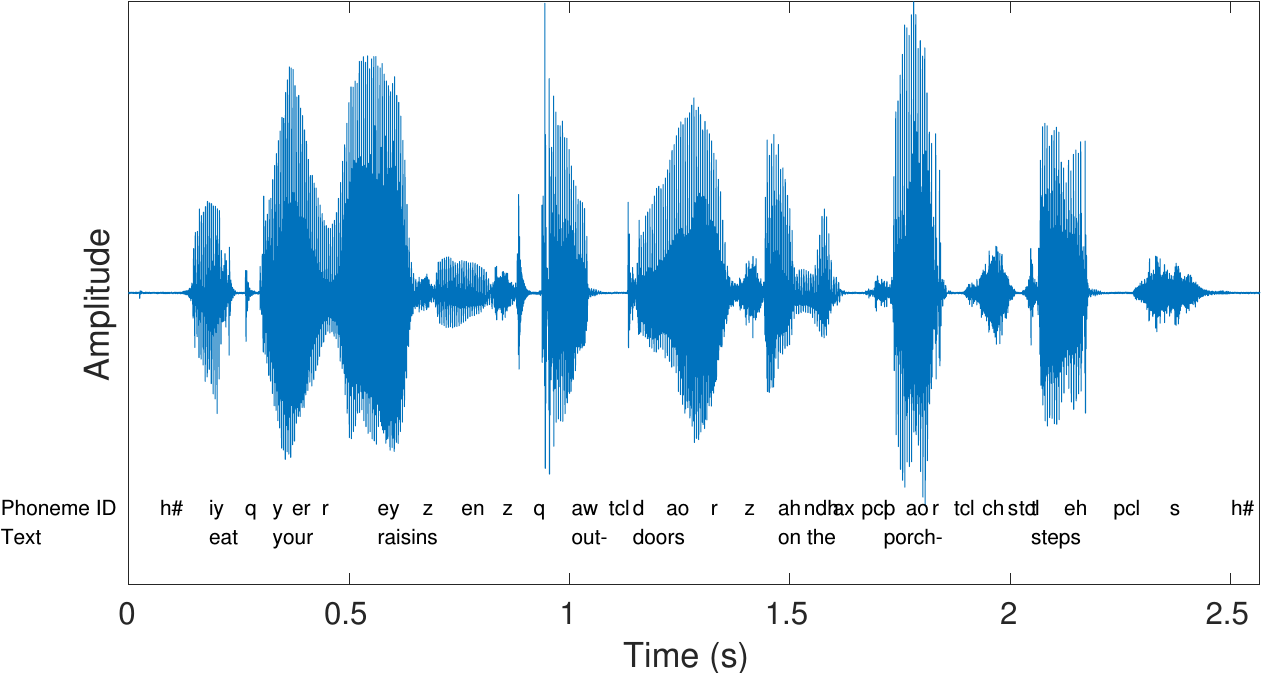

In [ ]:
from IPython.display import display, Image
Image(filename='attachments/148294966.png',width=600)

A spoken sentence is a sequence of phonemes. Speech signals are thus
time-variant in character. To extract information from a signal, we must
therefore split the signal into sufficiently short segments, such that,
heuristically speaking, each segment contains only one phoneme. In other
words, we want to extract segments which are short enough that the
properties of the speech signal does not have time change within that
segment.

*Windowing* is a classical method in signal processing and it refers to
splitting the input signal into temporal segments. The borders of
segments are then visible as discontinuities, which are incongruent with
the real-world signal. To reduce the impact of segmenting on the
statistical properties of the signal, we apply windowing to the temporal
segments. Windowing functions are smooth functions which go to zero at
the borders. By multiplying the input signal with a window function, the
windowing function also goes to zero at the border such that the
discontinuity at the border becomes invisible. Windowing does thus
change the signal, but the change is designed such that its effect on
signal statistics is minimized.

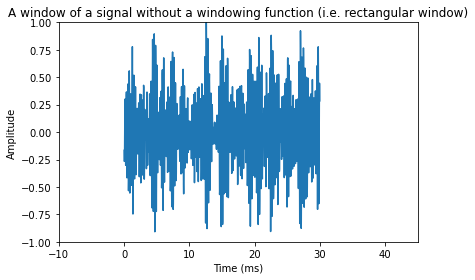

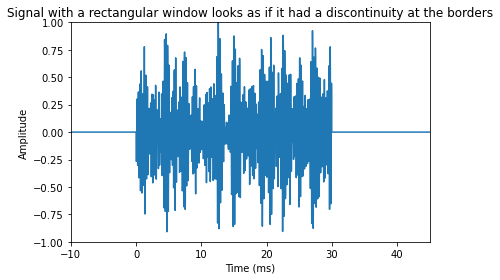

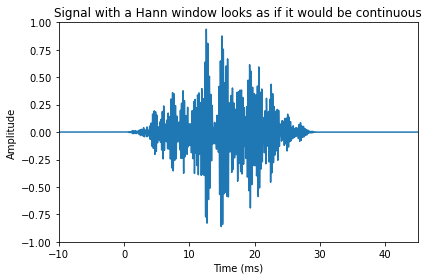

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile


# read from storage
filename = 'sounds/test.wav'
fs, data = wavfile.read(filename)

window_length_ms = 30
window_length = int(np.round(fs*window_length_ms/1000))

n = np.linspace(0.5,window_length-0.5,num=window_length)

# windowing function
windowing_fn = np.sin(np.pi*n/window_length)**2 # sine-window


datawin = data[38000:(38000+window_length)]
datawin = datawin/np.max(np.abs(datawin)) # normalize

plt.plot(n*1000/fs,datawin)
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('A window of a signal without a windowing function (i.e. rectangular window)')
plt.axis([-10.,45.,-1.,1.])
plt.tight_layout()
plt.show()

nx = np.concatenate(([-1000,0.],n,[window_length,window_length+1000]))
datax = np.concatenate(([0.,0.],datawin,[0.,0.]))
plt.plot(nx*1000/fs,datax)
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('Signal with a rectangular window looks as if it had a discontinuity at the borders')
plt.axis([-10.,45.,-1.,1.])
plt.tight_layout()
plt.show()

nx = np.concatenate(([-1000,0.],n,[window_length,window_length+1000]))
datax = np.concatenate(([0.,0.],datawin*windowing_fn,[0.,0.]))
plt.plot(nx*1000/fs,datax)
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('Signal with a Hann window looks as if it would be continuous')
plt.axis([-10.,45.,-1.,1.])
plt.tight_layout()
plt.show()

## Quick reference

There are two distinct applications of windowing with different
requirements; 1) analysis and 2) processing. In analysis, we only care
about extracting information as accurately as possible given
computational constraints, while in processing applications, we in
addition need the ability to recreate the signal from a sequence of
windows.

### Windowing for *analysis* applications

This is a classical signal processing topic covered by any basic book on
signal processing. Here we therefore present only the very
basics. Given an input signal $x_k$, defined for all $k$, and
a windowing function $w_k$, defined on a limited range $k\in[0,L) $ we can extract a window of the signal as

$$ x_{k,n}=x_{n-k}w_n. $$

A classical windowing function, the Hann-window $
w_n=\left[\sin\left(\pi n/L\right)\right]^2 $ is shown 
below.

The main optimization criteria in choosing windowing functions is
spectral distortion. Namely, we would like that the windowed signal
resembles the original signal as much as possible. However, since it is
only a short sample, it cannot be exact. As windowing is multiplication
in the time-domain (see above equation), it corresponds to convolution
in the frequency domain. By looking at the spectrum of the windowing
function, we can therefore determine how much spreading of peaks in the
frequency will occur when we apply the windowing function.
  

<!--<img src="attachments/148294947.png" height="250" />-->



  

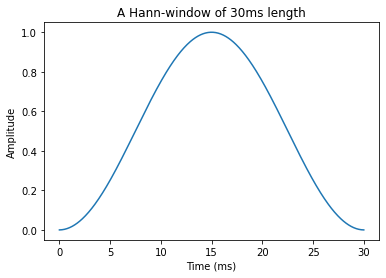

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# window parameters in milliseconds
window_length_ms = 30
fs = 16000

window_length = int(np.round(fs*window_length_ms/1000))

n = np.linspace(0.5,window_length-0.5,num=window_length)

# windowing function
windowing_fn = np.sin(np.pi*n/window_length)**2 # sine-window

plt.plot(n*1000/fs,windowing_fn)    
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('A Hann-window of 30ms length')
plt.show()

  

### Windowing for *processing* applications; Overlap-add

When we intend to modify the windowed signal with some processing, the
most common approach is to use a technique known as overlap-add. As seen
in the figure below, in overlap-add, we extract overlapping
windows of the signal, apply some processing, and reconstruct by
windowing a second time and then adding overlapping segments together.

An obvious requirement would then be that if the signal is not modified,
that we could then reconstruct the original signal perfectly; known as
the *perfect reconstruction* property. It is straightforward to
demonstrate that perfect reconstruction is achieved if overlapping
regions of the windowing function add up to unity. Note that here we
need to take into account the windowing is applied twice. That is, we
obtain perfect reconstruction if (Princen-Bradley criteria)

$$ w_n^2 + w_{n+L/2}^2 = 1.\qquad\text{for}\qquad k\in[0,L/2).
$$

Here the squares follow from the fact that windows are applied twice.
Note that subsequent windows are then at a distance of half $L/2$ the
length of the window.

A classical windowing function which follows the perfect reconstruction
criteria is the half-sine window, which is actually the square root of
the Hann-window. However, we have to here take special care that indices
are defined correctly, such that the half-sine is defined as $
w_n=\sin\left(\pi (n+0.5)/L\right). $ Observe that the difference
to the Hann-window is thus the absence of a square. It the follows that,
after squaring, overlapping parts add up to unity.

The length of windows in the figure below is 30 ms, while the
shift between windows is 15 ms. This is known as 50% overlap and it is
the most common approach, though it is possible to design low-overlap
windows (useful in low-delay applications). We can then observe that
analysis of the first window requires that we the signal is at least 30
ms long. *Analysis* of each additional window then requires 15 ms more
signal. That is, for analysis we have

$$ (Analysis\,signal\,length) = (windows-1)\times(step) +
(window\,length). $$

However, for reconstruction, we see that we have perfect reconstruction
only in the segment between 15 ms and 60 ms. That is, only those overlap
areas are perfectly reconstructed, where we have access to both the left
and right windows. For reconstruction we then have

$$ (Reconstruction\,signal\,length) = (windows-1)\times(step). $$

<img src="attachments//148295002.png" height="400" /><img src="attachments/148294911.png" height="72" />

## Comprehensive description

Specifically, suppose $x_k$ is the $k$th sample of the input
signal. Let $w_k$ be a windowing function (like the one in the
figure below) such that
$$ \begin{cases} w_k > 0 & k\in[0,L-1] \\ w_k = 0 & k < 0
\text{ and } k \geq L\\ w_k \rightarrow 0 & \text{near the
borders}. \end{cases} $$
The windowed signal of length $L$ is then
$$ x'_k = w_k x_k. $$
In classical signal processing, the main design criteria for
choosing $w_k$ are related to spectral resolution. Windowing
causes undesirable spreading of frequency components into nearby
frequencies and by choosing the windowing function, we can choose how
much and how far such a components are spread.

<img src="attachments/148294947.png" height="250" />


In difference to classical signal analysis, speech processing
applications have a range of additional requirements. Most importantly,
speech processing applications are not only analyzing the signals, but
their purpose is to reconstruct the (modified) signal. The figure on the
right illustrates the process. If the signal is not modified, commonly,
our objective is that the signal can be perfectly reconstructed from the
sequence of windows. This is known as the *perfect reconstruction*
property.

In other words, a transform is said to have perfect reconstruction if
the original signal can be recovered perfectly from the transformed
representation.

In application using windowing, perfect reconstruction is achieved with
a process known as *overlap-add* (sometimes abbreviated as
OLA) \cite{harris1978use,nuttall1971spectral}.

The basic principle of overlap and add is to apply windowing in
overlapping segments, such that when the windows are later added
together, the original signal is recovered (see Figure below).

<img src="attachments/148294943.png" height="250" />

As a first approach, let us define window $h$ as

$$ x_{k,h} = w_{k-Lh/2} x_k. $$

Subsequent windows $x_{k,h-1}$ and $x_{k,h}$, then have
non-zero portions which are overlapping (see figure) in
the region $ k\in[Lh/2,\, L(h+1)/2) $ . When we add them
together, we obtain

$$ \begin{split} x_{k,h-1} + x_{k,h} &= w_{k-L(h-1)/2} x_k +
w_{k-Lh/2} x_k \\&= \left(w_{k-L(h-1)/2} + w_{k-Lh/2}\right) x_k.
\end{split} $$

It follows that the reconstruction is exactly equal to the
original $x_{k,h-1} + x_{k,h}=x_k$, iff
$$ w_{k+L/2} + w_{k} = 1,\qquad\text{for } k\in[0,\,L/2). $$
An example of a window which satisfies this requirement is the raised
cosine (or Hann) window, illustrated below and defined as

$$ w_k = \frac12\left[1-\sin\left(\frac{ 2(k+0.5)\pi
}L\right)\right] =
\left[\sin\left(\frac{\pi(k+0.5)}L\right)\right]^2. $$

Unfortunately, when applying the above windowing in a processing
application, there is a problem. Suppose the windowed
signal $x_{k,h}$ is modified in some way, for example, the
signal could be quantized and coded for transmission. The receiving
device would then see a modified signal $ \hat x_{k,h} = x_{k,h} +
e_{k,h} $ , where $e_k,h$ is the modification applied to
window $h$ and $e_{k,h}$ is non-zero only for $ k \in [
Lh/2, L(h+1)/2) $ . The reconstructed signal, for the windows $h$ and
$h+1$, would then be (for $ k\in[Lh/2,\,L(h+1)/2) $ )

$$ \hat x_{k,h-1} + \hat x_{k,h} = x_k + e_{k,h-1} + e_{k,h}.
$$

The reconstruction error is thus $e_{k,h-1}+e_{k,h}$.
The problem here is that the modifications, $e_{k,h-1}$ and
$e_{k,h}$, appear here without windowing. Consequently, if the
modifications $e_{k,h}$ are non-zero near the window borders,
the reconstruction will have discontinuities.

  

<img src="attachments/148294947.png" height="250" />

  

To avoid discontinuities for the modification parts $e_{k,h}$,
we need to apply windowing also on the output signal. We therefore apply
windowing at both the input and output:

- Input: $x_k$
- Analysis windowing:  $ x_{k,h} = w^{\text{in}}_{k-Lh/2} x_k. $
- Processing: $ \hat x_{k,h} = x_{k,h}+e_{k,h}. $
- Synthesis windowing: $ \hat x_{k,h}' = w^{\text{out}}_{k-Lh/2} \hat x_{k,h}. $
- Overlap-add for the region $ k\in[Lh/2,\,L(h+1)/2):  \hat x'_k = \hat x_{k,h-1}'+\hat x_{k,h}'. $
- Output: $ \hat x'_k. $

The input and output windows are further illustrated in the Figure on
the right.

The output then has

$$ \begin{split} \hat x_{k,h-1}'+\hat x_{k,h} &=
w^{\text{out}}_{k-L(h-1)/2} \hat x_{k,h-1} +
w^{\text{out}}_{k-Lh/2} \hat x_{k,h} \\ &=
w^{\text{out}}_{k-L(h-1)/2}(x_{k,h-1}+e_{k,h-1}) +
w^{\text{out}}_{k-Lh/2} (x_{k,h}+e_{k,h}) \\ &=
w^{\text{out}}_{k-L(h-1)/2}(w_{\text{in},k-L(h-1)/2} x_k
+e_{k,h-1}) \\&\qquad+ w^{\text{out}}_{k-Lh/2}
(w_{\text{in},k-Lh/2} x_k+e_{k,h}) \\ &=
\left(w^{\text{out}}_{k-L(h-1)/2}w^{\text{in}}_{k-L(h-1)/2} +
w^{\text{out}}_{k-Lh/2} w^{\text{in}}_{k-Lh/2}\right) x_k
\\&\qquad +
w^{\text{out}}_{k-L(h-1)/2}e_{k,h-1}+w^{\text{out}}_{k-Lh/2}e_{k,h}.
\end{split} $$

We immediately observe that all output errors $e_{k,h}$ have
been multiplied with windowing functions, whereby discontinuities are
avoided. Moreover, perfect reconstruction is achieved iff

$$ w^{\text{out}}_{k+L/2}w^{\text{in}}_{k+L/2} +
w^{\text{out}}_{k} w^{\text{in}}_{k} =
1,\qquad\text{for } k\in[0,\,L/2). $$

This leaves us with the design task of two windowing functions, $
w^{\textrm{in}}_k $ and $ w^{\textrm{out}}_k $ .

To choose the output window, we can assume that the modifications to the
signal $e_{k,h}$ are uncorrelated white noise of zero mean and
variance $ \sigma^2 $ . The output error energy is then (for $
k\in[0,\,L/2) $ )

$$ \begin{split}
E&\left[\left(w^{\text{out}}_{k-L(h-1)/2}e_{k,h-1}+w^{\text{out}}_{k-Lh/2}e_{k,h}\right)^2\right]
\\& =
E\left[\left(w^{\text{out}}_{k-L(h-1)/2}e_{k,h-1}\right)^2\right]
+E\left[\left(w^{\text{out}}_{k-Lh/2}e_{k,h}\right)^2\right]
\\& = \left[\left(w^{\text{out}}_{k-L(h-1)/2}\right)^2
+\left(w^{\text{out}}_{k-Lh/2}\right)^2 \right]\sigma^2.
\end{split} $$

Modulations in signal energy are perceptually undesirable, whereby we
can require that

$$ \left(w^{\text{out}}_{k+L/2}\right)^2
+\left(w^{\text{out}}_{k}\right)^2 =
1,\qquad\text{for } k\in[0,\,L/2). $$

To simultaneously satisfy constraints on both input and output windows, we set $w_k=w^{\text{in}}_{k}=w^{\text{out}}_{k}$,
such that our only criteria is

$$ \boxed{w_{k+L/2}^2 + w_{k}^2 =
1,\qquad\text{for } k\in[0,\,L/2).} $$

This is known as the Princen-Bradley condition for overlapping
windows \cite{backstrom2017celp,
backstrom2013:win,Bosi:2003,edler1989codierung,malvar1990lapped,malvar1992signal}.

<img src="attachments/148294911.png" />

<img src="attachments/148295002.png" />

  

Several windowing functions which satisfy the above criteria are known.
In fact, from any window which satisfies the reconstruction criteria, we
can obtain a window which satisfies the Princen-Bradley condition by
taking the square root. For example, we have  the half-sine window

$$ w_k = \begin{cases} \sin\left(\frac{(k+0.5)\pi}{L}\right), &
\textrm{for } 0\leq k  < L\\ 0, &\textrm{otherwise} \end{cases}
$$

and the Kaiser-Bessel-derived (KBD) window

$$ w_k = \begin{cases} \gamma \sqrt{\sum_{h=0}^k
I_0\left(\pi\alpha \sqrt{1 -
\left(\frac{2h}{L-1}-1\right)^2}\right)}, & \textrm{for } 0\leq k
 < L\\ 0, &\textrm{otherwise}, \end{cases} $$

where $I_0()$ is the zeroth order modified Bessel function of
the first kind and γ is a scalar scaling coefficient chosen such that Princen-Bradley holds.

Another type of windowing which supports perfect reconstruction is
applied in speech codecs using the code-excited linear prediction (CELP)
paradigm. Here, temporal statistics of the signal are modeled with a
predictive (IIR) filter and the filter residual is windowed with square
windows \cite{backstrom2017celp,backstrom2013:win}. In practice, this
approach works only with a computationally complex analysis-by-synthesis
methodology, and it has not received much attention outside the speech
coding community.

In conclusion, windowing with overlap-add is a basic and commonly used
tool in speech processing. It allows algorithms to modify sections of
the signal such that the modifications do not cause discontinuities to
the signal. A properly designed windowing for overlap-add does not in
itself cause distortions and the original signal can be perfectly
reconstructed from the windows. The only notable disadvantage of
overlapping windowing is that overlaps cause redundancy, since
information which appears in an overlap region between windows $k$ and
$k+1$, will then always be included in computations in both window $k$
and $k+1$. Overlap-add processing can be modified to remove the
redundancy, by projecting the overlap area into two orthogonal
subspaces. Such methods are known as lapped transforms and are however
beyond the scope of the current
treatise \cite{edler1989codierung,backstrom2017celp,vilkamo2017timefrequency}.

In general, still, I would advise using perfect reconstruction methods
in all speech processing applications (except coding applications where
lapped transforms are preferred). The system is then deterministic in
the sense that all modifications are due to the main processing
algorithm and windowing will never cause surprising side-effects.